In [33]:
import sys
import os
import glob
import random
sys.path.append('../../..')

from model import processing
from matplotlib import pyplot as plt

from model import run
from model import plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, value_assets, usd_price, lrna_price
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)
# price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2023', days = 120)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.7999},
    'USD': {'usd price': 1, 'weight': 0.20},
    'TKN': {'usd price': 1, 'weight': 0.0001}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            asset_fee=0,
            lrna_fee=0,
            # withdrawal_fee=False
        )
    },
    agents = {
        'LP': Agent(
            holdings={'TKN': 10000},
            trade_strategy=invest_all('omnipool')
        ),
        'Arbitrageur': Agent(
            holdings={tkn: 10000000 for tkn in assets},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool',
                arb_precision=20
            )
        ),
    },
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    archive_all=False
)

In [49]:
steps = 101
price_min = 0.2
price_max = 5
step_factor = (price_max / price_min) ** (1 / (steps - 1))
price_move_range = [price_min * step_factor ** i for i in range(steps)]
events = []
# print(price_move_range)
weight_factors = [0.0001, 0.01, 0.02, 0.03, 0.05]


for w, weight in enumerate(weight_factors):
    assets = {
        'HDX': {'usd price': 0.05, 'weight': 0.8 - weight},
        'USD': {'usd price': 1, 'weight': 0.20},
        'TKN': {'usd price': 1, 'weight': weight}
    }

    for tkn, info in assets.items():
        liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
        lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

    initial_state.pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            asset_fee=0,
            lrna_fee=0,
            # withdrawal_fee=False
        )
    }
    
    events.append([])
    for price in price_move_range:
        price_list = [{'TKN': initial_state.external_market['TKN']}, {'TKN': price}]
        # print(price_list)
        initial_state._evolve_function = historical_prices(price_list)
        # events = run.run(initial_state, 1, silent=True)
        # print(events[-1].external_market)
        events[w].append(run.run(initial_state, 1, silent=True)[-1])
        # price_events[-1].pools['omnipool'].lrna['TKN'] *= price
        # print(price_events[-1].external_market)

<H1>Relationship between IL and price change</H1>
Here we show the impermanent loss incurred as a function of price shift. We assume that the price of TKN changes while the other assets in the pool do not. Because the price of LRNA is also responsive to the price of all assets in the Omnipool, a higher proportion of TKN leads to a stronger positive correlation between the prices of TKN and LRNA. Because IL is related to the change in TKN/LRNA price, this means that a higher weight of TKN in the pool results in a lower rate of IL. The different colors on this graph reprsent the IL resulting from different initial weights of TKN.

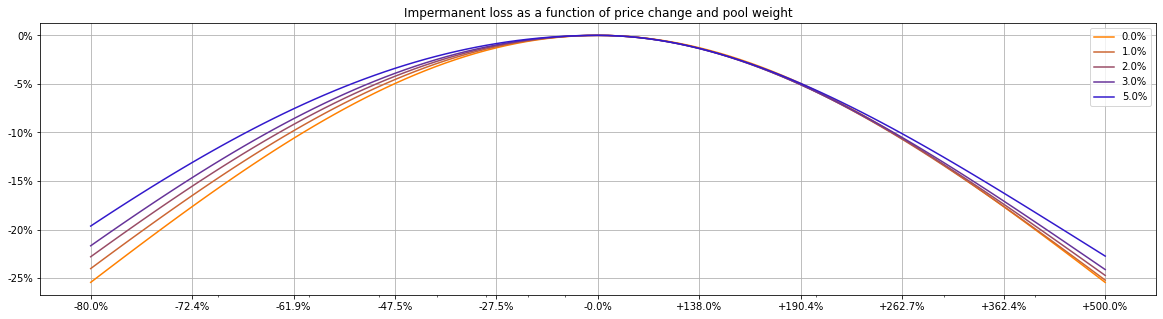

In [50]:
plt.figure(figsize=(20, 5))
plt.title('Impermanent loss as a function of price change and pool weight')

# plt.yscale('log')
plt.xscale('log')
graph_length = len(price_events)
xpoints = 11
x_step = (graph_length - 1) / (xpoints - 1)
x_ticks = [price_move_range[int(x_step * i)] for i in range(xpoints)]
x_labels = []
for t in x_ticks:
    if t < 1:
        x_labels.append(f'-{round((1 - t) * 100, 1)}%')
    else:
        x_labels.append(f'+{round(t * 100, 1)}%')
plt.xticks(x_ticks, x_labels)
plt.yticks(
    [.75, .80, .85, .90, .95, 1],
    ['-25%', '-20%', '-15%', '-10%', '-5%', '0%']
)
plt.grid()
colors = pu.color_gradient(len(events), color1=(255, 128, 0), color2=(0, 0, 255))
for i, price_events in enumerate(events):
    plt.plot(
        price_move_range, 
        [
            cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market)
            / value_assets(initial_state.agents['LP'].holdings, {'TKN': usd_price(event.pools['omnipool'], 'TKN')})
            for event in price_events
        ],
        color=colors[i]
    )
plt.legend([f'{round(weight * 100, 0)}%' for weight in weight_factors])